# Capacity Data Cleaning

This notebook works with:

- Planet Data

  * Reads raw Planet data
  * Removes duplicates from the data
  * Cleans the data by relabelling proper nans and adjusting the time dimension
  * Makes a CDF matching of data from period 1 using data from period 2 as a baseline

- ERA-5 Data

  * Reads raw ERA-5 data
  * Removes duplicates from the data
  * Cleans the data
  * Selects nearest neightbor for each pixel to match the grid of period 2
  * Makes a CDF matching of ERA-5 using data from period 2 as a baseline

After those steps:
  * Joins the three datasets along the time dimension
  * Stores the data as a NetCDF file


In [1]:
import sys
import os
cp = '/home/jupyter-gabriel/' #'I:/My Drive/'
sys.path.append(cp + "projects/suyana")
from scripts.utils.functions import *

In [12]:
# Data primary path
dpp = 'suyana/'
# Data inputs path
dip = 'suyana/inputs/'
# Data features path
dfp = 'suyana/features/'
# Data outputs path
dop = 'suyana/outputs/'
# Data reports path
drp = 'suyana/reports/'
# Data models path
dmp = 'suyana/models/'
# Data displays path
ddp = 'suyana/displays/'
# Data geometries path
dgp = 'suyana/geometries/'

In [2]:
def coarsen_data(ds, params_coarse):
    ds_new = ds.coarsen(params_coarse, boundary = 'pad').mean()
    return ds_new

In [3]:
def remove_duplicates(ds):
    ds_unique = ds.drop_duplicates(..., keep='first')

    return ds_unique


def clean_data(
    ds, 
    date_range = (None, None), 
    na_replace = None, 
    time_dim = 'time', 
    params_smooth = {'time':21}, 
    params_offset = {'lon':0, 'lat':0}
):
    # Remove duplicates
    if time_dim not in ds.dims:
        raise ValueError(f"Input for time_dim must be a subset of dimensions")
    ds = remove_duplicates(ds)
    
    # Convert time to datetime format
    ds[time_dim] = pd.to_datetime(ds[time_dim].values)
    
    # Create a week coordinate attached to the existing time dimension
    ds = ds.assign_coords(dict(
        week = (time_dim, ds[time_dim].dt.isocalendar().week.values)
    ))

    ds = ds.reindex(
        time=pd.date_range(
            start=ds[time_dim].min().values, end=ds[time_dim].max().values, freq="D"
        )
    )

    # Select data within the time window
    if date_range[0] is None and date_range[1] is None:
        pass
    else:
        ds = ds.sel(time = slice(date_range[0], date_range[1]))
    
    # Replace values with nan (65535 for Planet)
    if isinstance(na_replace, (int, float)):
        ds = ds.where(ds != na_replace, np.nan)

    # Apply a rolling mean to have a smooth time series by pixel
    ds = ds.rolling(params_smooth, min_periods = 1).mean()

    # Adjust the coordinates by an offset value
    for key, value in params_offset.items():
        ds[key] = ds[key] + value

    return ds

def summarize_data(ds, red_dims=[None], group_coords=[None]):
    
    if set(red_dims).issubset(set(list(ds.sizes.keys()))):
        # Average over all grouping columns (dimensions)
        ds = ds.mean(dim = red_dims)
    elif set(group_coords).issubset(set(list(ds.coords))):
        for coord in group_coords:
            ds = ds.groupby(coord).mean()
    else:
        raise ValueError(f"Input for red_cols must be a subset of dimensions")
    return ds

In [4]:
# Function to assign a cluster to a single (lon, lat) pair
def assign_cluster(lon, lat, shapes, cluster_var):
    point = Point(lon, lat)
    for _, row in shapes.iterrows():
        if row["geometry"].contains(point):
            return row[cluster_var]  # Assuming 'cluster_id' is in the shapefile
    return np.nan  # Default if no cluster matches

def create_cluster_coord(ds, shapefile, cluster_var, lon_var='lon', lat_var='lat'):
    # Apply cluster assignment to all (lon, lat) pairs
    # Extract lon and lat from the dataset
    lon = ds[lon_var].values
    lat = ds[lat_var].values

    # Create a 2D meshgrid of (lon, lat) pairs
    lon_grid, lat_grid = np.meshgrid(lon, lat)

    # Use np.vectorize to apply the assign_cluster function
    vectorized_assign_cluster = np.vectorize(assign_cluster, excluded=["shapes", "cluster_var"])
    cluster = vectorized_assign_cluster(lon_grid, lat_grid, shapes=shapefile, cluster_var=cluster_var)

    # Add the cluster as a new coordinate to the dataset
    ds = ds.assign_coords(cluster=((lat_var, lon_var), cluster))
    
    return ds


In [5]:
def empirical_cdf_matching_grouped(df_fix, df_orig, field, group_cols):
    """
    Performs empirical CDF matching, handling NaN values.

    Args:
      x: The data to be adjusted.
      y: The reference data.

    Returns:
      The adjusted data.
    """
    df_base = df_orig[group_cols + [field]].copy()
    df_base['index'] = df_base.groupby(group_cols)[field].rank(method="first")
    df_base = df_base.dropna(subset=[field],axis=0)

    df_base_size = df_base.groupby(group_cols).agg(
        size=(field, 'count')
    ).reset_index()

    df_base = df_base.rename({field: field+'_adjusted'}, axis=1)
    
    df_fix['rank'] = (
        df_fix.groupby(group_cols)[field].rank(method="max")
        / df_fix.groupby(group_cols)[field].transform('count')
    )
    
    df_fix = df_fix.merge(
        df_base_size,
        how = 'left',
        on = group_cols
    )

    df_fix['index'] = np.floor(df_fix['rank']*df_fix['size'])
    
    df_fix = df_fix.merge(
        df_base[group_cols +['index', field+'_adjusted']],
        how = 'left',
        on = group_cols + ['index']
    ).drop(labels=['index', 'size', 'rank'], axis=1)

    return df_fix

def empirical_cdf_matching(df_fix, df_orig, field, group_cols = None):
    if group_cols is None:
        df_fix['aux__var'] = 1
        df_orig['aux__var'] = 1
        group_cols = ['aux__var']
        df_fix = empirical_cdf_matching_grouped(df_fix, df_orig, field, group_cols)
        df_fix.drop(group_cols, axis=1, inplace=True)
        df_orig.drop(group_cols, axis=1, inplace=True)
    else:
        df_fix = empirical_cdf_matching_grouped(df_fix, df_orig, field, group_cols)
    return df_fix

In [6]:
def cdf_matching_grouped(ds_period1, ds_period2, field, group_cols=None, time_dim = 'time', adjust_field_base = False):
    
    # Turn the xarrays into dataframes to apply the empirical_cdf_matching function
    df_fix = ds_period1.to_dataframe().reset_index()
    df_base = ds_period2.to_dataframe().reset_index()
    
    df_fix = empirical_cdf_matching(
        df_fix, df_base, field , group_cols
    )
    if adjust_field_base: 
        ds_period2[field+'_adjusted'] = ds_period2[field] 
    
    # Create an xarray Dataset
    dims = list(ds_period2.sizes.keys())
    coords = list(ds_period2.coords.keys())
    drop_vars = list(set(coords) - set(dims))

    df_fix.drop(['week'], axis=1, inplace=True)

    ds_period1 = df_fix.set_index(dims).to_xarray()
    
    #ds_period1 = ds_period1.set_coords(coords)
    #ds_period1 = ds_period1.drop_vars(drop_vars)
    
    ds_period1 = ds_period1.assign_coords(dict(
        week = (time_dim, ds_period1[time_dim].dt.isocalendar().week.values)
    ))
    return ds_period1, ds_period2


In [7]:
def scale_data_grouped(df_fix, df_orig, field, time_dim, group_cols=None):
    
    min_day = min(df_fix[time_dim].dt.dayofyear.values)
    max_day = max(df_fix[time_dim].dt.dayofyear.values)
    
    df_base = df_orig.loc[(df_orig[time_dim].dt.dayofyear >= min_day) & (df_orig[time_dim].dt.dayofyear <= max_day)].copy()

    df_base = df_base.groupby(group_cols).agg(
        mean_field = (field, 'mean'),
        std_field = (field, 'std'),
    ).reset_index()

    df_fix['local_mean'] = df_fix.groupby(group_cols)[field].transform('mean')
    df_fix['local_std'] = df_fix.groupby(group_cols)[field].transform('std')

    df_fix  = df_fix.merge(
        df_base,
        how = 'left',
        on = group_cols
    )

    df_fix[field + '_adjusted'] = ((df_fix[field] - df_fix['local_mean'])/df_fix['local_std']) *df_fix['std_field']  + df_fix['mean_field']
    
    df_fix = df_fix.drop(labels=['local_mean', 'local_std', 'std_field', 'mean_field'], axis=1)
    
    return df_fix

def scale_data(df_fix, df_orig, field, time_dim = 'time', group_cols = None):
    if group_cols is None:
        df_fix['aux__var'] = 1
        df_orig['aux__var'] = 1
        group_cols = ['aux__var']
        df_fix = scale_data_grouped(df_fix, df_orig, field, time_dim, group_cols)
        df_fix.drop(group_cols, axis=1, inplace=True)
        df_orig.drop(group_cols, axis=1, inplace=True)
    else:
        df_fix = scale_data_grouped(df_fix, df_orig, field, time_dim, group_cols)
    return df_fix

In [8]:
def scaling_grouped(ds_period1, ds_period2, field,  time_dim = 'time', group_cols=None, adjust_field_base = False):
    
    # Turn the xarrays into dataframes to apply the empirical_cdf_matching function
    df_fix = ds_period1.to_dataframe().reset_index()
    df_base = ds_period2.to_dataframe().reset_index()
    
    df_fix = scale_data(
        df_fix, df_base, field , time_dim, group_cols
    )
    if adjust_field_base: 
        ds_period2[field+'_adjusted'] = ds_period2[field] 
    
    # Create an xarray Dataset
    dims = list(ds_period2.sizes.keys())
    coords = list(ds_period2.coords.keys())
    drop_vars = list(set(coords) - set(dims))
    #df_fix = df_fix.drop(['week'], axis=1)
    ds_period1 = df_fix.set_index(dims).to_xarray()
    
    ds_period1 = ds_period1.set_coords(coords)
    #ds_period1 = ds_period1.drop_vars(drop_vars)
    #ds_period1 = ds_period1.assign_coords(dict(
    #    week = (time_dim, ds_period1[time_dim].dt.isocalendar().week.values)
    #))

    return ds_period1, ds_period2


In [9]:
def create_window_w_data(ds_orig, ds_base, date_range = (None, None)):
    
    # Select data within the time window
    if date_range[0] is None and date_range[1] is None:
        ds_fill = ds_orig
    else:
        ds_fill = ds_orig.sel(time = slice(date_range[0], date_range[1]))

    # Select the nearest neighbors from the grid pixels on ds_base
    ds_fill = ds_fill.sel(
        lat = ds_base.lat, lon = ds_base.lon, method = 'nearest'
    )
    ds_fill = ds_fill.assign_coords(
        lat = ds_base.lat, 
        lon = ds_base.lon, 
        time = ds_fill.time.dt.round('d'),
        week = ('time', ds_fill.time.dt.isocalendar().week.values)
    )

    return ds_fill

In [10]:
def create_empty_data(ds_orig, gdf, date_range = (None, None), cluster_var='nro_cluste', lon_var='lon', lat_var='lat'):
    
    # Select data within the time window
    if date_range[0] is None and date_range[1] is None:
        ds_fill = ds_orig
    else:
        ds_fill = ds_orig.sel(time = slice(date_range[0], date_range[1]))

    # Select the nearest neighbors from the grid pixels on ds_base
    ds_fill = create_cluster_coord(ds_fill, gdf, cluster_var, lon_var, lat_var)
    ds_fill = ds_fill.assign_coords(
        time = ds_fill.time.dt.round('d'),
        week = ('time', ds_fill.time.dt.isocalendar().week.values)
    )

    return ds_fill

In [11]:
def concat_arrays(ds_ini, dim_along = None, *ds_arrays):
    if set([dim_along]).issubset(set(list(ds_ini.sizes.keys()))):
        # Create a list of all datasets to concatenate
        all_ds = [ds_ini] + list(ds_arrays)
        
        # Perform concatenation
        ds_final = xr.concat(all_ds, dim=dim_along)
    else:
        raise ValueError(f"Input for dim_along must be a subset of dimensions")
    
    # Sort and rename as needed
    if dim_along in ds_final.dims:
        ds_final = ds_final.sortby(dim_along)
        
    return ds_final

In [13]:
ds_period1 = xr.open_dataset(dpp + 'drought/swc/raw/canton_215/canton_215_1.nc')
ds_period2 = xr.open_dataset(dpp + 'drought/swc/raw/canton_215/canton_215_2.nc')
ds_era = xr.open_dataset(dip + 'drought_soilwater_2011_2012.nc')
gdf = gpd.read_file(dgp + 'canton_001.shp')
if not set(['nro_cluste']).issubset(gdf.columns):
    gdf['nro_cluste'] = np.nan
gdf['id_cluster'] = gdf['nro_cluste'].rank(method = 'first').fillna(7)

In [45]:
lon_offset = np.mean((ds_period2.lon.values[1:] - ds_period2.lon.values[:-1])/2)
lat_offset = np.mean((ds_period2.lat.values[1:] - ds_period2.lat.values[:-1])/2)

In [46]:
date_ini = max((ds_period1.time + np.timedelta64(1, "D")).dt.date.astype(str).values)
date_fin = min((ds_period2.time - np.timedelta64(1, "D")).dt.date.astype(str).values)

In [47]:
ds_period1 = clean_data(ds_period1, date_range=(None, date_ini), na_replace=65535, params_smooth = {'time':21}, params_offset = {'lon':lon_offset, 'lat':lat_offset})
ds_period2 = clean_data(ds_period2, date_range=(date_fin, '2024-10-31'), na_replace=65535, params_smooth = {'time':21}, params_offset = {'lon':lon_offset, 'lat':lat_offset})

In [48]:
ds_period1 = create_cluster_coord(ds_period1, gdf, 'id_cluster')
ds_period2 = create_cluster_coord(ds_period2, gdf, 'id_cluster')

<Figure size 600x600 with 0 Axes>

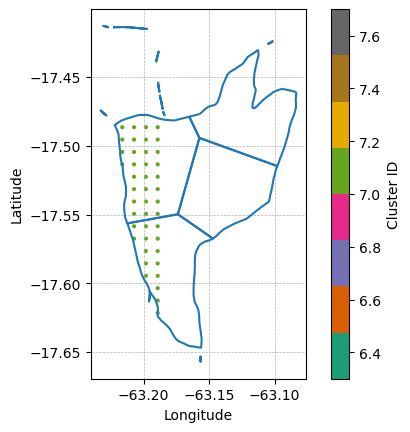

In [49]:
ds_with_clusters = ds_period2.mean(dim='time')#.sel(cluster=np.nan).plot()
cluster_grid = ds_with_clusters["cluster"].values

# Create 2D coordinate grids matching the shape of cluster_grid
lon_grid, lat_grid = np.meshgrid(ds_with_clusters["lon"].values, ds_with_clusters["lat"].values)

# Flatten all arrays for scatter plot
lon_flat = lon_grid.ravel()
lat_flat = lat_grid.ravel()
clusters_flat = cluster_grid.ravel()

# Plot the grid
plt.figure(figsize=(6, 6))
gdf.boundary.plot()
plt.scatter(
    lon_flat,
    lat_flat,
    c = clusters_flat,
    #shading="auto",
    cmap="Dark2",  # Use a categorical colormap for cluster IDs
    #marker='s',
    #edgecolor='k',
    s = 4,
)
plt.colorbar(label="Cluster ID")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(visible=True, linestyle="--", linewidth=0.5)
plt.show()

In [57]:
#ds_period1_ = coarsen_data(ds_period1, params_coarse={'lon':3, 'lat':3})
#ds_period2_ = coarsen_data(ds_period2, params_coarse={'lon':3, 'lat':3})

In [58]:
#ds_empty = create_window_w_data(ds_era, ds_period2, date_range=(date_ini, date_fin))

In [102]:
ds_empty = clean_data(ds_era, date_range=(date_ini, date_fin), params_smooth={'time':14})
ds_empty = create_cluster_coord(ds_empty, gdf, cluster_var='nro_cluste')

In [103]:
ds_period1 = summarize_data(ds_period1, group_coords=['cluster'])
ds_period2 = summarize_data(ds_period2, group_coords=['cluster'])
ds_empty = summarize_data(ds_empty, group_coords=['cluster'])

In [104]:
'''
ds_period1 = summarize_data(ds_period1, group_cols=['lon', 'lat'])
ds_period2 = summarize_data(ds_period2, group_cols=['lon', 'lat'])
ds_empty = summarize_data(ds_empty, group_cols=['lon', 'lat'])
'''

"\nds_period1 = summarize_data(ds_period1, group_cols=['lon', 'lat'])\nds_period2 = summarize_data(ds_period2, group_cols=['lon', 'lat'])\nds_empty = summarize_data(ds_empty, group_cols=['lon', 'lat'])\n"

In [105]:
ds_period1, ds_period2 = cdf_matching_grouped(ds_period1, ds_period2, 'swc', group_cols=['week'], adjust_field_base=True)

In [106]:
ds_empty, ds_period2 = cdf_matching_grouped(ds_empty, ds_period2, 'swc')

In [107]:
ds_concat = concat_arrays(ds_period1, 'time', ds_empty, ds_period2)

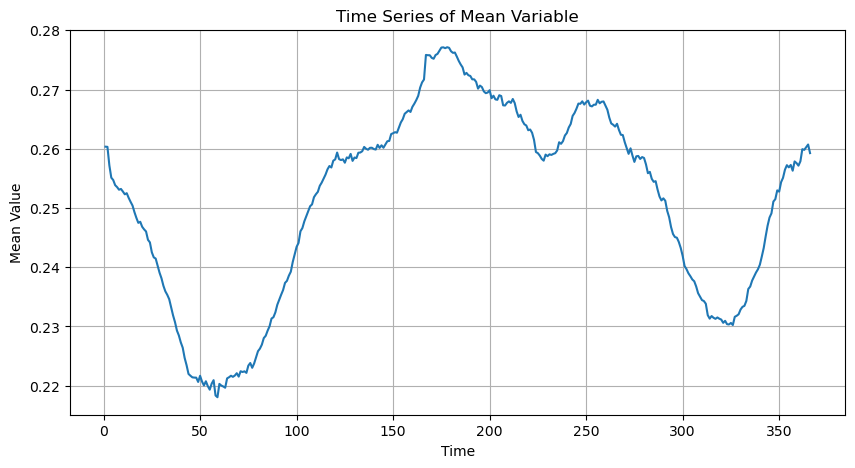

In [109]:
# Take the mean over lat and lon to get a time series
time_series = ds_concat.sel(cluster=2.0)['swc_adjusted'].groupby('time.dayofyear').mean()

# Plot the time series
plt.figure(figsize=(10, 5))
time_series.plot()
plt.xlabel("Time")
plt.ylabel("Mean Value")
plt.title("Time Series of Mean Variable")
plt.grid()
plt.show()

# Create clean datasets from raw datasets from Planet and ERA-5

In [14]:
# Read the yields panel dataset to clean only the required values of canton
df_yields_final = pd.read_csv(dip+'drought_yields_panel_id.csv')

In [17]:
path = dpp+"drought/swc/raw/"
files = os.listdir(path)
files = [f for f in files if f.startswith("canton")]
id_canton = [files[i].split("_")[1] for i in range(len(files))]

list_ids = sorted(list(set(df_yields_final['id_canton'].astype(str)).intersection(set(id_canton))))
list_ids

['189', '195', '209', '43', '49', '52', '54', '56', '57']

In [18]:
ds_era = xr.open_dataset(dip + 'drought_soilwater_2011_2012.nc')
ds_era = ds_era.rolling(time = 14, min_periods=1).mean()

In [ ]:
for id in list_ids:
    print(f"Canton: {id}")
    local_path = path + 'canton_' + str(id) + '/'
    files = sorted(os.listdir(local_path))
    for i in range(len(files)):
        if i==0:
            ds_period1 = xr.open_dataset(local_path + files[i])
        if i > 0:
            ds_period2 = xr.open_dataset(local_path + files[i])
            #netcdf_ini = xr.concat([netcdf_ini, netcdf_aux], dim='time')

    #Obtener bordes de la ventana temporal
    date_ini = max((ds_period1.time + np.timedelta64(1, "D")).dt.date.astype(str).values)
    date_fin = min((ds_period2.time - np.timedelta64(1, "D")).dt.date.astype(str).values)

    ds_period1 = clean_data(ds_period1, date_range=(None, date_ini), na_replace=65535, params_smooth = {'time':21})
    ds_period2 = clean_data(ds_period2, date_range=(date_fin, '2024-10-31'), na_replace=65535, params_smooth = {'time':21})
    
    ds_period1 = summarize_data(ds_period1, group_coords=['cluster'])
    ds_period2 = summarize_data(ds_period2, group_coords=['cluster'])
    ds_empty = summarize_data(ds_empty, group_coords=['cluster'])
    
    ds_empty = create_window_w_data(ds_era, ds_period2, date_range=(date_ini, date_fin))
    

    ds_empty = clean_data(ds_empty, date_range=(date_ini, date_fin), params_smooth={'time':1})
    print(f"Cleaning done")

    ds_period1, ds_period2 = cdf_matching_grouped(ds_period1, ds_period2, 'swc', group_cols=['lon', 'lat', 'week'], adjust_field_base=True)
    ds_empty, ds_period2 = cdf_matching_grouped(ds_empty, ds_period2, 'swc')
    print(f"CDF matching done")
    
    ds_concat = concat_arrays(ds_period1, 'time', ds_empty, ds_period2)
    print(f"Filling empty window done and concatenating arrays")


    comp = dict(zlib=True, complevel=9)
    encoding = {var: comp for var in ds_concat.data_vars}
    
    ds_concat.to_netcdf(
        dip + 'drought_canton_processed_' + str(id) +'.nc',
        encoding = encoding
    )

Canton: 189
Cleaning done
CDF matching done
Filling empty window done and concatenating arrays
Canton: 195
Cleaning done
CDF matching done
Filling empty window done and concatenating arrays
Canton: 209
Cleaning done
CDF matching done
Filling empty window done and concatenating arrays
Canton: 43
Cleaning done
CDF matching done
Filling empty window done and concatenating arrays
Canton: 49
Cleaning done
CDF matching done
Filling empty window done and concatenating arrays
Canton: 52
Cleaning done
CDF matching done
Filling empty window done and concatenating arrays
Canton: 54
Cleaning done
CDF matching done
Filling empty window done and concatenating arrays
Canton: 56
Cleaning done
CDF matching done
Filling empty window done and concatenating arrays
Canton: 57
Cleaning done
CDF matching done
Filling empty window done and concatenating arrays


In [16]:
ds_concat.sizes

Frozen({'time': 8175, 'lat': 14, 'lon': 20})

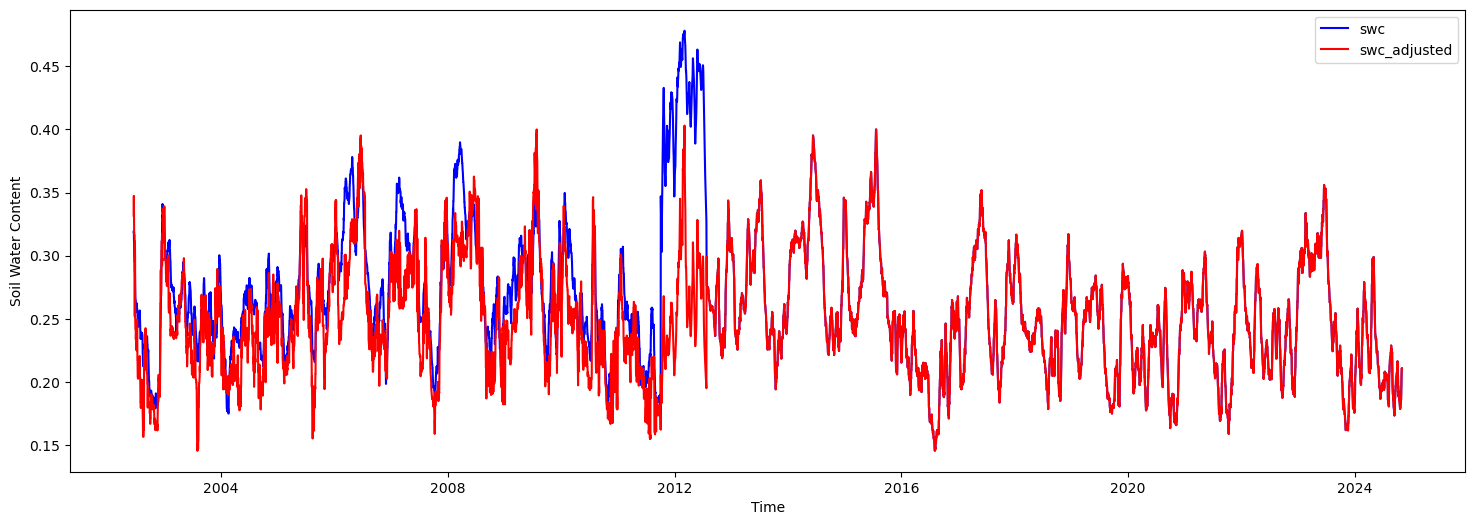

In [17]:
# Select the data at the specific location 
ds_location = ds_concat.isel(lon=0, lat=13)
#ds_location = ds_location.sel(time=slice('2010-10-01', '2013-07-31'))
# Plotting 
plt.figure(figsize=(18, 6)) 
plt.plot(ds_location.time, ds_location.swc, label='swc', color='blue') 
plt.plot(ds_location.time, ds_location.swc_adjusted, label='swc_adjusted', color='red') 
plt.xlabel('Time') 
plt.ylabel('Soil Water Content')
plt.legend()
plt.show()

In [18]:
climatology = ds_concat.groupby('time.dayofyear').mean(dim = ['time', 'lon', 'lat'])
ds_climatology = xr.DataArray(
    climatology['swc_adjusted'].sel(dayofyear=ds_concat['time.dayofyear']), dims = ['time']
)

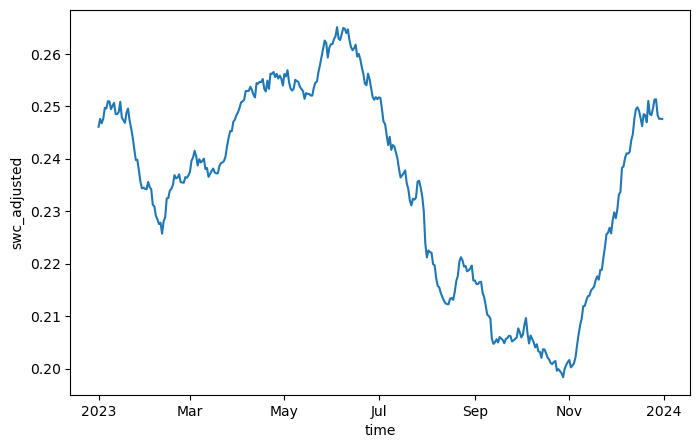

In [19]:
# Plotting 
ds_climatology = ds_climatology.sel(time=slice('2023-01-01', '2023-12-31'))
plt.figure(figsize=(8, 5)) 
ds_climatology.plot()

# Create clean datasets from raw datasets from Planet and ERA-5 with clusters from shapefiles

In [19]:
path = dip + "drought/swc/raw/"
path_polygons = dgp
files = os.listdir(path_polygons)
files = [f for f in files if f.endswith(".shp")]
id_canton = [files[i].split("_")[1].split(".")[0] for i in range(len(files))]

In [21]:
ds_era = xr.open_dataset(dip + 'drought_soilwater_2011_2012.nc')
lat_fine = np.arange(ds_era.lat.min(), ds_era.lat.max() + 0.025, 0.025)
lon_fine = np.arange(ds_era.lon.min(), ds_era.lon.max() + 0.025, 0.025)
# Interpolate to the finer resolution
ds_interp = ds_era.interp(lat=lat_fine, lon=lon_fine, method="linear")

# Inspect the interpolated data
print(ds_interp)

<xarray.Dataset> Size: 140MB
Dimensions:  (time: 731, lat: 165, lon: 145)
Coordinates:
  * time     (time) datetime64[ns] 6kB 2011-01-01T08:00:00 ... 2012-12-31T08:...
  * lat      (lat) float64 1kB -18.9 -18.88 -18.85 ... -14.85 -14.83 -14.8
  * lon      (lon) float64 1kB -64.3 -64.27 -64.25 ... -60.75 -60.72 -60.7
Data variables:
    swc      (time, lat, lon) float64 140MB 0.4165 0.4186 0.4207 ... 0.4702 nan
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-01-21T15:44 GRIB to CDM+CF via cfgrib-0.9.1...


In [260]:
id_canton[53:63]

['214', '165', '50', '121', '129', '86', '55', '72', '84', '158']

In [ ]:
for id in ['214']:#id_canton[53]: #[0:52] #53(canton_214) is too small that it need a finer grid
    print(f"Canton: {id}")
    local_path = path + 'canton_' + str(id) + '/'
    files = sorted(os.listdir(local_path))
    for i in range(len(files)):
        if i==0:
            ds_period1 = xr.open_dataset(local_path + files[i])
        if i > 0:
            ds_period2 = xr.open_dataset(local_path + files[i])
            #netcdf_ini = xr.concat([netcdf_ini, netcdf_aux], dim='time')

    gdf = gpd.read_file(path_polygons + 'canton_' + str(id) + '.shp')
    gdf['id_cluster'] = gdf['nro_cluste'].rank(method = 'first').fillna(7)
    
    # Get offset value for grid
    lon_offset = np.mean((ds_period2.lon.values[1:] - ds_period2.lon.values[:-1])/2)
    lat_offset = np.mean((ds_period2.lat.values[1:] - ds_period2.lat.values[:-1])/2)

    # Get boundaries of temporal window
    date_ini = max((ds_period1.time + np.timedelta64(1, "D")).dt.date.astype(str).values)
    date_fin = min((ds_period2.time - np.timedelta64(1, "D")).dt.date.astype(str).values)

    ds_period1 = clean_data(ds_period1, date_range=(None, date_ini), na_replace=65535, 
                            params_smooth = {'time':21},  params_offset={'lon':lon_offset, 'lat':lat_offset})
    ds_period2 = clean_data(ds_period2, date_range=(date_fin, '2024-10-31'), na_replace=65535, 
                            params_smooth = {'time':21}, params_offset={'lon':lon_offset, 'lat':lat_offset})
    ds_empty = clean_data(ds_interp, date_range=(date_ini, date_fin), params_smooth={'time':14})
    print(f"Cleaning done")

    ds_period1 = create_cluster_coord(ds_period1, gdf, 'id_cluster')
    ds_period2 = create_cluster_coord(ds_period2, gdf, 'id_cluster')
    ds_empty = create_cluster_coord(ds_empty, gdf, 'id_cluster')

    ds_period1 = summarize_data(ds_period1, group_coords=['cluster'])
    ds_period2 = summarize_data(ds_period2, group_coords=['cluster'])
    ds_empty = summarize_data(ds_empty, group_coords=['cluster'])

    ds_period1, ds_period2 = cdf_matching_grouped(ds_period1, ds_period2, 'swc', group_cols=['week'], adjust_field_base=True)
    ds_empty, ds_period2 = cdf_matching_grouped(ds_empty, ds_period2, 'swc')
    print(f"CDF matching done")
    
    ds_concat = concat_arrays(ds_period1, 'time', ds_empty, ds_period2)
    print(f"Filling empty window and concatenating arrays done")


    comp = dict(zlib=True, complevel=9)
    encoding = {var: comp for var in ds_concat.data_vars}
    
    ds_concat.to_netcdf(
        dip + 'drought_canton_cluster_' + str(id) +'.nc',
        encoding = encoding
    )

Canton: 214
Cleaning done
CDF matching done
Filling empty window and concatenating arrays done


In [255]:
points = ds_interp[['lon', 'lat']].to_dataframe().reset_index().drop_duplicates()

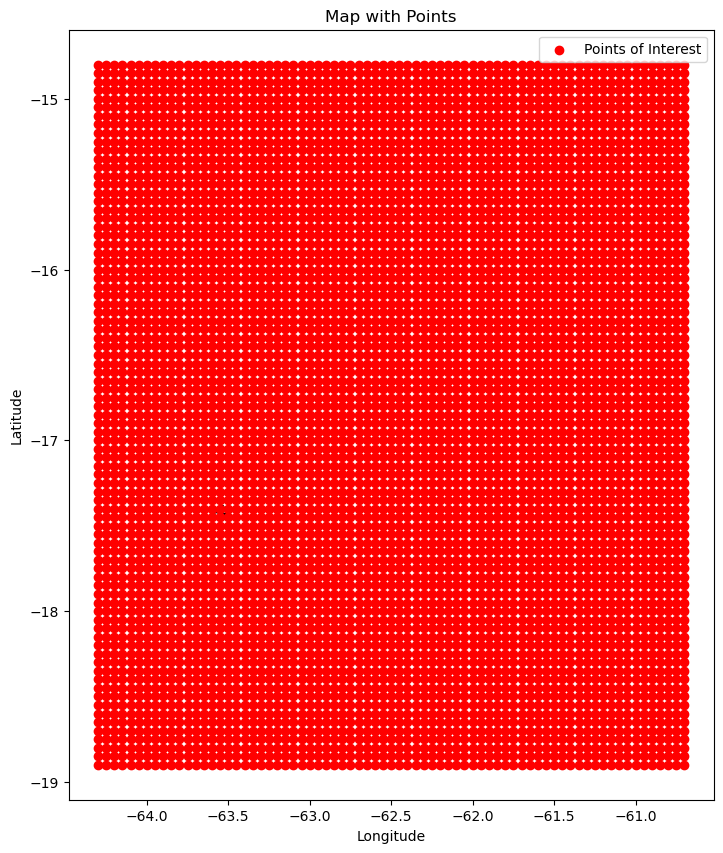

In [256]:
# Extract coordinates into separate lists
x_coords = points['lon']
y_coords = points['lat']

# Plot the GeoDataFrame
ax = gdf.plot(color='lightgrey', edgecolor='black', figsize=(10, 10))

# Add points to the plot
plt.scatter(x_coords, y_coords, color='red', label='Points of Interest')

# Customize the plot
plt.title("Map with Points")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()

# Show the plot
plt.show()

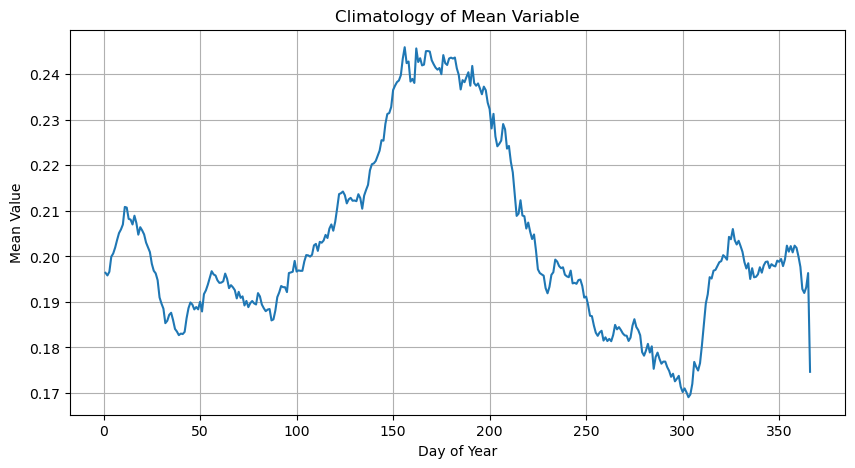

In [265]:
ds = ds_concat.sel(cluster=1)['swc_adjusted'].groupby('time.dayofyear').mean()

# Plot the time series
plt.figure(figsize=(10, 5))
ds.plot()
plt.xlabel("Day of Year")
plt.ylabel("Mean Value")
plt.title("Climatology of Mean Variable")
plt.grid()
plt.show()

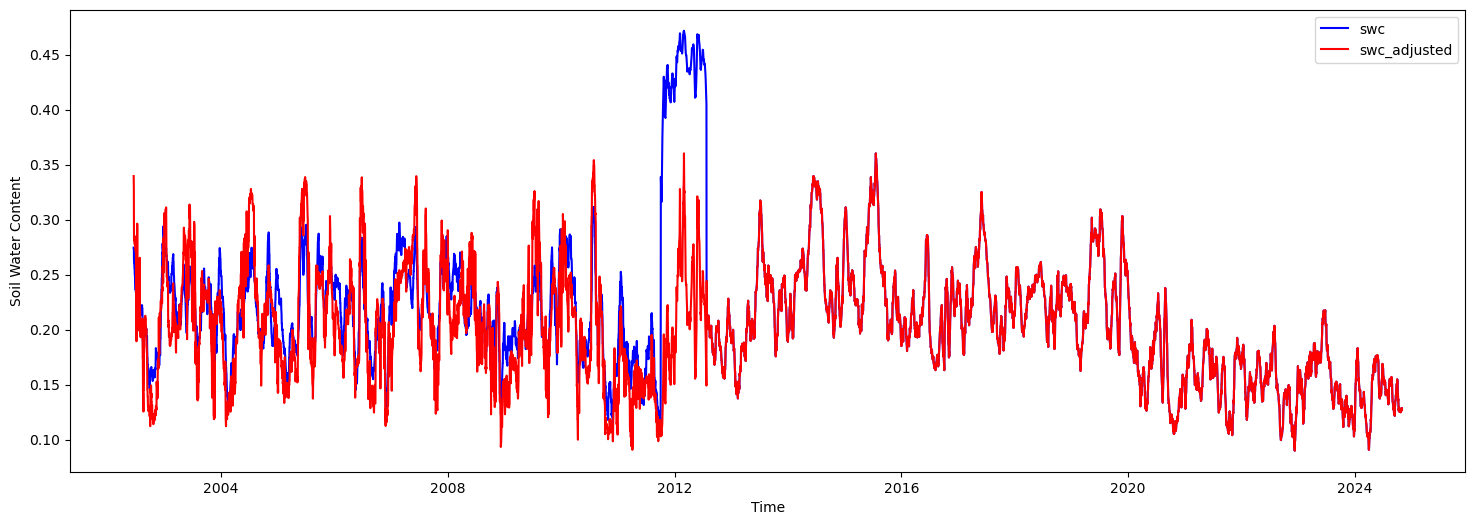

In [266]:
# Select the data at the specific location 
ds_location = ds_concat.sel(cluster=1)
#ds_location = ds_location.sel(time=slice('2010-10-01', '2013-07-31'))
# Plotting 
plt.figure(figsize=(18, 6)) 
plt.plot(ds_location.time, ds_location.swc, label='swc', color='blue') 
plt.plot(ds_location.time, ds_location.swc_adjusted, label='swc_adjusted', color='red') 
plt.xlabel('Time') 
plt.ylabel('Soil Water Content')
plt.legend()
plt.show()

# Auxiliary exploratory data

In [5]:
len(id_canton)

66

In [6]:
gdf = gpd.read_file(path_polygons + 'canton_' + str(196) + '.shp')
gdf

ERROR 1: PROJ: proj_create_from_database: Open of /opt/tljh/user/share/proj failed


,canton_id,nro_cluste,area_m2,fid,id_canton,ogc_fid,entity,canton_ori,provincia,municipio,departamen,area,canton,priority,fid_2,id_canton_,ogc_fid_2,entity_2,canton_o_1,provincia_,municipio_,departam_1,area_2,canton_2,priority_2,...,fid_2_2,id_canto_2,ogc_fid_2_,entity_2_2,canton_o_3,provinci_2,municipi_2,departam_3,area_2_2,canton_2_2,priority_1,id_2_2,left_2_2,top_2_2,right_2_2,bottom_2_2,row_inde_2,col_inde_2,CLUSTER__1,canton_id_,nro_clus_1,area_m2_2,layer_2,path_2,geometry
0,canton_196_2.nc,6.0,9.973888e+07,197.0,196.0,924.0,Polyline,Cotoca,Andres Iba?ez,Cotoca,Santa Cruz,613.302308,Cotoca_1,0.0,197.0,196.0,924.0,Polyline,Cotoca,Andres Iba?ez,Cotoca,Santa Cruz,613.302308,Cotoca_1,0,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"POLYGON ((-62.83234 -17.75039, -62.75711 -17.7..."
1,canton_196_2.nc,2.0,1.028446e+08,197.0,196.0,924.0,Polyline,Cotoca,Andres Iba?ez,Cotoca,Santa Cruz,613.302308,Cotoca_1,0.0,197.0,196.0,924.0,Polyline,Cotoca,Andres Iba?ez,Cotoca,Santa Cruz,613.302308,Cotoca_1,0,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-62.85692 -17.66792, -62.85277..."
2,canton_196_2.nc,5.0,1.464032e+08,197.0,196.0,924.0,Polyline,Cotoca,Andres Iba?ez,Cotoca,Santa Cruz,613.302308,Cotoca_1,0.0,197.0,196.0,924.0,Polyline,Cotoca,Andres Iba?ez,Cotoca,Santa Cruz,613.302308,Cotoca_1,0,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"POLYGON ((-62.94338 -17.77221, -62.95239 -17.7..."
3,canton_196_2.nc,4.0,1.023751e+08,197.0,196.0,924.0,Polyline,Cotoca,Andres Iba?ez,Cotoca,Santa Cruz,613.302308,Cotoca_1,0.0,197.0,196.0,924.0,Polyline,Cotoca,Andres Iba?ez,Cotoca,Santa Cruz,613.302308,Cotoca_1,0,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"POLYGON ((-62.93144 -17.79730, -62.93144 -17.8..."
4,canton_196_2.nc,0.0,1.233154e+08,197.0,196.0,924.0,Polyline,Cotoca,Andres Iba?ez,Cotoca,Santa Cruz,613.302308,Cotoca_1,0.0,197.0,196.0,924.0,Polyline,Cotoca,Andres Iba?ez,Cotoca,Santa Cruz,613.302308,Cotoca_1,0,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"POLYGON ((-62.97001 -17.76027, -62.97748 -17.7..."
5,canton_196_2.nc,2.0,1.028446e+08,125.0,124.0,756.0,Polyline,Puerto Pailas,Andres Iba?ez,Cotoca,Santa Cruz,6.477018,Puerto Pailas_1,0.0,125.0,124.0,756.0,Polyline,Puerto Pailas,Andres Iba?ez,Cotoca,Santa Cruz,6.477018,Puerto Pailas_1,0,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"POLYGON ((-62.77956 -17.67294, -62.77970 -17.6..."
6,None,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,NaN,None,NaN,NaN,72.0,932.0,Polyline,Curiche,Cordillera,Cabezas,Santa Cruz,1617.904165,Curiche_2,0,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-62.93203 -17.84571, -62.93144..."


In [7]:
gdf_full = []
for id in id_canton:
    print(f"Canton: {id}")
    gdf = gpd.read_file(path_polygons + 'canton_' + str(id) + '.shp')

    gdf_full.append(gdf)

Canton: 87
Canton: 196
Canton: 56
Canton: 220
Canton: 120
Canton: 53
Canton: 199
Canton: 128
Canton: 172
Canton: 211
Canton: 43
Canton: 209
Canton: 49
Canton: 163
Canton: 168
Canton: 164
Canton: 237
Canton: 198
Canton: 126
Canton: 122
Canton: 125
Canton: 70
Canton: 218
Canton: 127
Canton: 106
Canton: 194
Canton: 166
Canton: 169
Canton: 191
Canton: 215
Canton: 57
Canton: 167
Canton: 190
Canton: 45
Canton: 54
Canton: 207
Canton: 83
Canton: 171
Canton: 80
Canton: 192
Canton: 002
Canton: 82
Canton: 85
Canton: 189
Canton: 81
Canton: 195
Canton: 001
Canton: 162
Canton: 51
Canton: 208
Canton: 210
Canton: 105
Canton: 173
Canton: 202
Canton: 52
Canton: 214
Canton: 165
Canton: 50
Canton: 121
Canton: 129
Canton: 86
Canton: 55
Canton: 72
Canton: 84
Canton: 158
Canton: 170


In [8]:
gdf_final = gpd.GeoDataFrame(pd.concat(gdf_full,ignore_index=True), crs=gdf_full[0].crs)

/tmp/ipykernel_117686/935483770.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gdf_final = gpd.GeoDataFrame(pd.concat(gdf_full,ignore_index=True), crs=gdf_full[0].crs)


In [9]:
len(gdf_final.canton_id.unique())

66

In [10]:
gdf_final.total_bounds

array([-64.23328368, -18.41302891, -60.74770719, -16.14827108])

<Axes: >

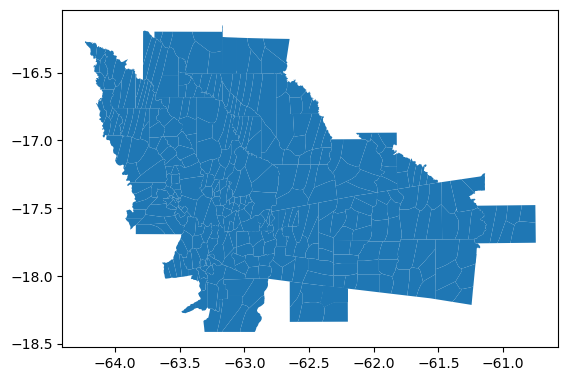

In [11]:
gdf_final[gdf_final['id_canton']!=2000].plot() #

<Axes: >

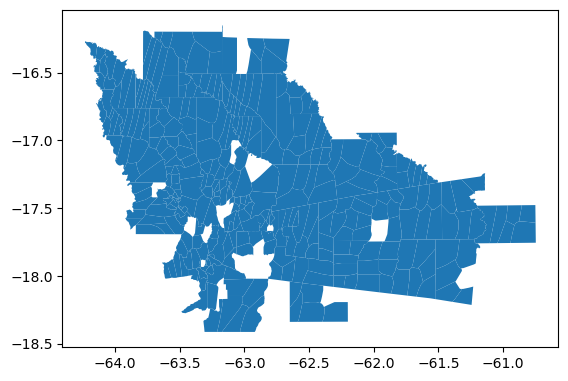

In [24]:
gdf_final[gdf_final['id_canton']!=2000].plot() #

In [39]:
x = gdf_final.groupby('canton_id').agg(
    nans=('nro_cluste', lambda x: x.isna().sum()),
    n_clust=('nro_cluste', lambda x: len(x.unique()))
).reset_index()

x.loc[x['nans']>0,:]

,canton_id,nans,n_clust
1,canton_106_2.nc,1,1
3,canton_121_2.nc,1,1
7,canton_127_2.nc,1,1
8,canton_128_2.nc,3,3
31,canton_199_2.nc,1,1


In [46]:
for i in x.loc[x['n_clust']<6,:]['canton_id']:
    print(i)

canton_105_2.nc
canton_106_2.nc
canton_120_2.nc
canton_121_2.nc
canton_122_2.nc
canton_126_2.nc
canton_127_2.nc
canton_128_2.nc
canton_162_2.nc
canton_167_2.nc
canton_173_2.nc
canton_190_2.nc
canton_191_2.nc
canton_195_2.nc
canton_196_2.nc
canton_198_2.nc
canton_199_2.nc
canton_202_2.nc
canton_214_2.nc
canton_237_2.nc
canton_53_2.nc
canton_54_2.nc
canton_80_2.nc
canton_81_2.nc
canton_84_2.nc
canton_87_2.nc


In [53]:
gdf_final.drop_duplicates(subset=['canton_id', 'nro_cluste']).shape

(329, 26)

In [17]:
canton_189 = xr.open_dataset(cp + 'suyana/drought/swc/raw/canton_43/canton_43_2.nc')#.to_dataframe().reset_index()

In [120]:
gdf_189 = gdf_final.loc[gdf_final['id_canton']==43,:].copy()

In [30]:
np.mean((canton_189.lon.values[1:] - canton_189.lon.values[:-1])/2)

0.004504504504505036

In [121]:
points = canton_189[['lon', 'lat']].drop_duplicates()

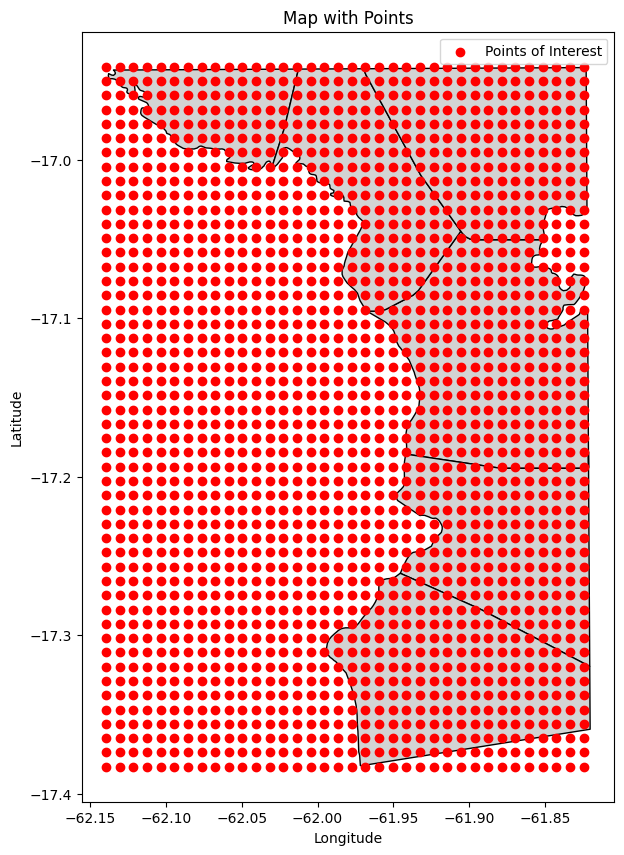

In [122]:
# Extract coordinates into separate lists
x_coords = points['lon']
y_coords = points['lat']

# Plot the GeoDataFrame
ax = gdf_189.plot(color='lightgrey', edgecolor='black', figsize=(10, 10))

# Add points to the plot
plt.scatter(x_coords, y_coords, color='red', label='Points of Interest')

# Customize the plot
plt.title("Map with Points")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()

# Show the plot
plt.show()

In [125]:
gdf_189.total_bounds

array([-62.13808467, -17.38234266, -61.82009736, -16.94198265])

In [147]:
max(points['lat'])+0.004504499999999467

-16.936936941443307

In [137]:
(-17.382883-(-17.373874))/2

-0.004504499999999467

In [136]:
points[['lat']].drop_duplicates().sort_values(by=['lat'])

,lat
219814,-17.382883
215328,-17.373874
210842,-17.364865
206356,-17.355856
201870,-17.346847
...,...
17944,-16.977477
13458,-16.968468
8972,-16.959459
4486,-16.950450
